In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


In [2]:
os.getcwd()

'/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04'

## 1. 인물모드 직접 해보기
### 이미지 가져와서 배경과 고양이 분리

In [ ]:
#이미지 가져오기
img_path = '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/tricolor_cat.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1080, 1920, 3)


In [ ]:
#PixelLib에서 제공해 주는 모델을 다운로드
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

In [ ]:
#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [ ]:
#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [ ]:
#모델에서 나온 출력값
plt.imshow(output)
plt.show()

In [ ]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [ ]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [ ]:
colormap[8] #컬러맵 8에 해당하는 배열 출력, pecalvoc에 LABEL_NAMES cat

In [ ]:
seg_color = (0, 0, 64 ) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [ ]:
#원본이미지를 img_show에 할당
img_show = img_orig.copy()

#True와 False인 값을 각각 255와 0으로 바꿔줌
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

In [ ]:
#blur() 함수를 이용하여 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (41,41))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))

In [ ]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용하 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) #채널 변경
img_bg_mask = cv2.bitwise_not(img_mask_color)#배경 0, 고양이 255 -> 배경 255, 고양이 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
#흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 전환

In [ ]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용하여 고양이만 추출
# 고양이 부분만 추출
img_fg_mask = img_mask_color  # 객체가 255, 배경이 0
img_fg = cv2.bitwise_and(img_orig, img_fg_mask)

# 배경 이미지 불러오기
img_path = '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/background.png'  
bg_image = cv2.imread(img_path)

# 배경 리사이즈
bg_image_resized = cv2.resize(bg_image, (img_fg.shape[1], img_fg.shape[0]))

# 마스크 컬러화
np_mask = np.array(img_mask)
image_mask_color = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)

# 최종 합성
concat_image = np.where(image_mask_color == 255, img_fg, bg_image_resized)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(concat_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 다른 사진도 적용해보기

In [ ]:
def segmentation_with_new_background(img_path, bg_path):
    # 이미지 불러오기
    img_orig = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    #라벨 출력
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
        
    #ouput
    plt.imshow(output)
    plt.show()
    
    # 고양이 색상 지정
    seg_color = (0, 0, 64)
    seg_map = np.all(output == seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255

    # 마스크 컬러화
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 고양이 부분만 추출
    img_fg = cv2.bitwise_and(img_orig, img_mask_color)

    # 배경 이미지 불러오기 및 리사이즈
    bg_image = cv2.imread(bg_path)
    bg_image_resized = cv2.resize(bg_image, (img_orig.shape[1], img_orig.shape[0]))

    # 최종 합성
    concat_image = np.where(img_mask_color == 255, img_fg, bg_image_resized)

    return concat_image


In [ ]:
# 사용할 이미지 목록
img_list = [
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cats.png',
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cat_with_monitor.png',
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cat_with_tree.png'
]
img_path ='/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cats.png'


# 배경 이미지 경로
bg_path = '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/background.png'
result = segmentation_with_new_background(img_path, bg_path)

    # 결과 출력
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 사용할 이미지 목록
img_list = [
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cats.png',
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cat_with_monitor.png',
    '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/cat_with_tree.png'
]

# 배경 이미지 경로
bg_path = '/workspace/userdisk/AIFFEL_quest_cr/AIFFEL_quest_rs/Exploration/Ex04/background.png'

# 이미지 3장 반복 처리
for img_path in img_list:
    result = segmentation_with_new_background(img_path, bg_path)

    # 결과 출력
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


## 2. 사진에서 문제점 찾기
- 배경에 따라 사진의 경계선이 부자연 스러움
- 고양이 꼬리,귀 주변에 뭉개지거나 이미지 잘림 현상
- 털, 귀, 꼬리 같은 부위는 얇고 배경의 색, 패턴 질감과 비슷해서 이미지가 잘림
- 이미지를 2D 방식으로 처리하였기 때문에 객체의 깊이, 거리 차이 등을 인식하지 못함
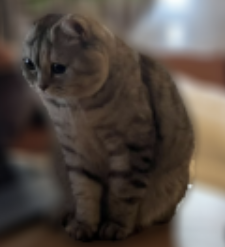
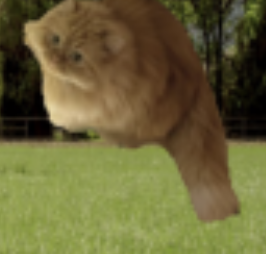

## 3. 해결 방법 제안
- https://wikidocs.net/251708
- Depth Maps 확장 프로그램은 Stable Diffusion에서 이미지의 깊이 정보를 생성하고 활용할 수 있도록 도와주는 도구입니다. 이 확장은 2D 이미지에서 3D 정보(깊이 맵)를 추출하여 보다 현실감 있는 이미지나 다양한 3D 응용 작업에 활용할 수 있습니다.
- Depth Map의 밝은 픽셀은 상대적으로 가까운 물체이며 어두운 픽셀은 상대적으로 멀리 있는 물체이다. 
- depth 값에 다라 blur mask 나누기
- Blur 여러 장 만든 다음 Depth 영역별로 붙여서 최종 이미지 완성.

